In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.legend_handler import HandlerLine2D

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import robust_scale
from sklearn.metrics import r2_score

# sklearn models
from sklearn.ensemble import RandomForestRegressor

# Inputing Files

In [2]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})

In [3]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})

In [4]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)

In [5]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.drop(['STNAME','CTYNAME'], axis=1)
county_pop = county_pop.rename(columns={"COUNTY": "fips"})

In [6]:
education = pd.read_csv('Education.csv')
education = education.rename(columns={"FIPS Code": "fips", 
                            "Less than a high school diploma, 2010-2014": "< HS",
                            "High school diploma only, 2010-2014":"HS", 
                            "Some college or associate's degree, 2010-2014": "Some College",
                            "Bachelor's degree or higher, 2010-2014": "Bachelors",
                            "Percent of adults with less than a high school diploma, 2010-2014" : "% < HS",
                            "Percent of adults with a high school diploma only, 2010-2014" : "% HS",
                            "Percent of adults completing some college or associate's degree, 2010-2014" : "% Some College",
                            "Percent of adults with a bachelor's degree or higher, 2010-2014" : "% Bachelors"})

education = education.drop(["State", "Area name"], axis=1)

## Merging Dataframes Together

In [7]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df = df.merge(county_cases, how="left", on="fips")
df = df.merge(education, how="left", on="fips")
df['% < HS']  = df['% < HS'] / 100
df['% HS'] = df['% HS'] / 100
df['% Some College'] = df['% Some College'] / 100
df['% Bachelors'] = df['% Bachelors'] / 100
df = df.drop(["< HS","HS","Some College","Bachelors"], axis=1)
df

,fips,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,cases,deaths,% < HS,% HS,% Some College,% Bachelors
0,1001,55869,0.053,0.074,0.134,0.295,0.444,604.49,2059,31,0.138,0.335,0.307,0.219
1,1003,223234,0.083,0.059,0.098,0.323,0.436,2027.08,6658,69,0.110,0.288,0.316,0.286
2,1005,24686,0.067,0.121,0.120,0.201,0.491,904.59,1033,9,0.254,0.334,0.275,0.136
3,1007,22394,0.020,0.034,0.096,0.278,0.572,625.50,840,14,0.221,0.401,0.276,0.102
4,1009,57826,0.053,0.114,0.180,0.194,0.459,650.65,1932,25,0.219,0.345,0.313,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,56037,42343,0.061,0.295,0.230,0.146,0.268,10491.73,462,2,0.095,0.358,0.366,0.181
3124,56039,23464,0.095,0.157,0.160,0.247,0.340,4221.96,747,1,0.043,0.192,0.246,0.519
3125,56041,20226,0.098,0.278,0.154,0.207,0.264,2087.66,431,3,0.108,0.330,0.374,0.187
3126,56043,7805,0.204,0.155,0.069,0.285,0.287,2242.85,144,7,0.109,0.316,0.363,0.212


## Create Features

In [8]:
df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']
#df = df.reindex(columns=["fips","cases","deaths","POPESTIMATE2019","AREA","POP_DEN","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS", "% < HS", "% HS", "% Some College", "% Bachelors"])
df.corr()

,fips,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,cases,deaths,...,POP_DENxALWAYS,POP_DENxFREQUENTLY,POP_DENxSOMETIMES,POP_DENxRARELY,POP_DENxNEVER,POPxALWAYS,POPxFREQUENTLY,POPxSOMETIMES,POPxRARELY,POPxNEVER
fips,1.000000,-0.059759,-0.005946,-0.032730,-0.053094,-0.079669,0.067678,-0.095848,-0.061754,-0.060394,...,0.045434,0.048019,0.041609,0.060079,0.047674,-0.059760,-0.057547,-0.054029,-0.043305,-0.059415
POPESTIMATE2019,-0.059759,1.000000,-0.197458,-0.212442,-0.207021,-0.146798,0.293856,0.033140,0.948347,0.882777,...,0.403166,0.363006,0.379722,0.304360,0.281419,0.996040,0.977600,0.939626,0.802543,0.870841
NEVER,-0.005946,-0.197458,1.000000,0.427057,0.321972,0.048232,-0.684970,-0.031426,-0.154615,-0.164789,...,-0.190713,-0.181805,-0.170181,-0.139536,-0.028845,-0.197652,-0.211618,-0.188140,-0.157080,-0.036819
RARELY,-0.032730,-0.212442,0.427057,1.000000,0.361163,0.144707,-0.728386,-0.023864,-0.171201,-0.189642,...,-0.214479,-0.198176,-0.185632,-0.048947,-0.134918,-0.216080,-0.217675,-0.191822,-0.040318,-0.149401
SOMETIMES,-0.053094,-0.207021,0.321972,0.361163,1.000000,0.073084,-0.668399,-0.043233,-0.160765,-0.182864,...,-0.207939,-0.182432,-0.089888,-0.124853,-0.117300,-0.214487,-0.207638,-0.105349,-0.141687,-0.146075
FREQUENTLY,-0.079669,-0.146798,0.048232,0.144707,0.073084,1.000000,-0.515229,0.095512,-0.125457,-0.152364,...,-0.133157,-0.053463,-0.086973,-0.060088,-0.075106,-0.161306,-0.084290,-0.115480,-0.084654,-0.120490
ALWAYS,0.067678,0.293856,-0.684970,-0.728386,-0.668399,-0.515229,1.000000,-0.002344,0.235681,0.265965,...,0.286686,0.234398,0.203894,0.144315,0.136314,0.304143,0.275487,0.230891,0.164613,0.174626
AREA,-0.095848,0.033140,-0.031426,-0.023864,-0.043233,0.095512,-0.002344,1.000000,0.033832,0.020698,...,-0.043972,-0.053514,-0.062964,-0.071940,-0.061798,0.035736,0.027142,0.019376,0.016323,0.018155
cases,-0.061754,0.948347,-0.154615,-0.171201,-0.160765,-0.125457,0.235681,0.033832,1.000000,0.901118,...,0.359359,0.323946,0.350198,0.278701,0.263041,0.943261,0.918677,0.912745,0.767105,0.853026
deaths,-0.060394,0.882777,-0.164789,-0.189642,-0.182864,-0.152364,0.265965,0.020698,0.901118,1.000000,...,0.450002,0.395173,0.414330,0.286018,0.304772,0.884036,0.844118,0.827941,0.667824,0.782588


## Normalize Data

In [9]:
def normalize(data):
    dataf=((data-data.min())/(data.max()-data.min()))*20
    return dataf

In [10]:
def new_normal(dataframe):
    normal = robust_scale(dataframe)
    return normal

## df with outliers eliminated

In [11]:
df_outliers = df.drop(df[df['cases']>=25000].index, axis=0)
column_titles = ["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]
df_outliers = new_normal(df_outliers.reindex(columns=column_titles))
df_outliers = pd.DataFrame(df_outliers)
df_outliers.columns = column_titles
df_outliers['fips'] = df['fips']
df_outliers = df_outliers.merge(county_cases, how="left", on="fips")
column_titles = ["fips","cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN"]
df_outliers = df_outliers.reindex(columns=column_titles)

## normal df

In [12]:
def normalize_df(df, titles):
    normal_df = pd.DataFrame(new_normal(df.reindex(columns=titles)))
    normal_df.columns = titles
    normal_df['fips'] = df['fips']
    normal_df = normal_df.merge(county_cases, how="left", on="fips")
    column_titles = ["fips","cases","deaths"].append(titles)
    normal_df = normal_df.reindex(columns=column_titles)
    return normal_df

In [13]:
normal_df = normalize_df(df,["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","POP_DEN"])

In [14]:
normal_df_ed = normalize_df(df,["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","POP_DEN", "% < HS", "% HS", "% Some College", "% Bachelors"])

## Histogram of preprocessing

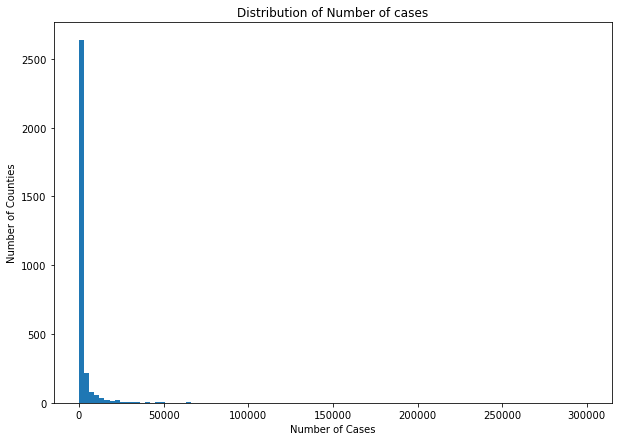

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df['cases'],bins=100)
plt.ylabel('Number of Counties') 
plt.xlabel('Number of Cases')
plt.title('Distribution of Number of cases')
plt.show()

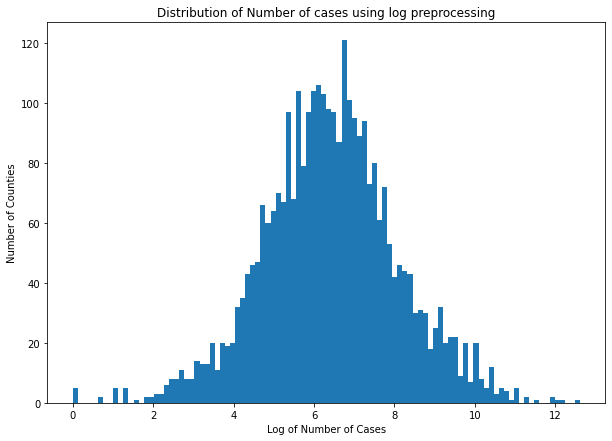

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(np.log(df['cases']),bins=100)
plt.ylabel('Number of Counties') 
plt.xlabel('Log of Number of Cases')
plt.title('Distribution of Number of cases using log preprocessing')
plt.show()

## Split Data

In [17]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size)

## Random Forest Regression

In [18]:
l = ["POPESTIMATE2019","POP_DEN","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS", "% < HS", "% HS", "% Some College", "% Bachelors",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
l2 = ["POPESTIMATE2019","POP_DEN", "% < HS", "% HS", "% Some College", "% Bachelors",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
l3 = ["POPESTIMATE2019","POP_DEN",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
l4 = ["POPESTIMATE2019","POP_DEN","% HS", "% Bachelors","ALWAYS",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
new_df = normalize_df(df,l)
x_train, x_test, y_train, y_test = split(new_df.drop(['fips','cases','deaths'], axis=1), np.log(df['cases']), 0.3)

In [19]:
percents = np.arange(0.75, 1, 0.1)
sizes = np.arange(100, 141, 10)
clf = RandomForestRegressor(bootstrap=True)
grid = {'max_samples':percents, 'n_estimators':sizes}
clf_cv = GridSearchCV(estimator = clf, param_grid = grid)
clf_cv.fit(x_train, y_train)
best_n_estimators = clf_cv.best_params_['n_estimators']
best_max_samples = clf_cv.best_params_['max_samples']

print('Best n_estimators:', best_n_estimators)
print('Best max_samples:', best_max_samples)

Best n_estimators: 130
Best max_samples: 0.95


In [20]:
best_n_estimators = 120
best_max_samples = .85
clf = RandomForestRegressor(n_estimators=best_n_estimators, max_samples=best_max_samples, bootstrap=True)
clf.fit(x_train, y_train)
print("MSE:", MSE(clf.predict(x_test), y_test))

MSE: 0.36284878113308644


## More Robust Grid search, remove values as they  get trained and remain constant

In [21]:
percents = [0.25,0.4,0.65,0.75,0.85]
depths = [11]
splits = [2,4]
clf = RandomForestRegressor(bootstrap=True,n_estimators=120)
grid = {'max_samples':percents, 'max_depth':depths, 'min_samples_split':splits}
clf_cv = GridSearchCV(estimator = clf, param_grid = grid)
clf_cv.fit(x_train, y_train)
best_max_samples = clf_cv.best_params_['max_samples']
best_max_depth = clf_cv.best_params_['max_depth']
best_min_samples_split = clf_cv.best_params_['min_samples_split']

print('Best max_samples:', best_max_samples)
print('Best max_depth:', best_max_depth)
print('Best min_samples_split:', best_min_samples_split)

Best max_samples: 0.75
Best max_depth: 11
Best min_samples_split: 4


In [22]:
best_max_samples= 0.75
best_max_depth= 11
best_min_samples_split= 4

In [23]:
clf = RandomForestRegressor(n_estimators=120, max_samples=best_max_samples, bootstrap=True,max_depth=best_max_depth,min_samples_split=best_min_samples_split)
clf.fit(x_train, y_train)
print("MSE:", MSE(clf.predict(x_test), y_test))

MSE: 0.3599241499841617


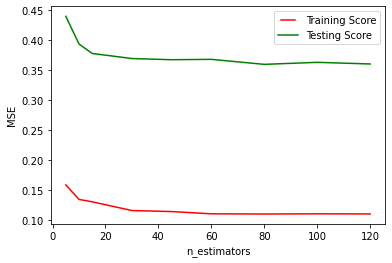

In [24]:
train_results = []
test_results = []
list_nb_trees = [5, 10, 15, 30, 45, 60, 80, 100, 120]

for nb_trees in list_nb_trees:
    rf = RandomForestRegressor(n_estimators=nb_trees, max_samples=best_max_samples, bootstrap=True,min_samples_split=best_min_samples_split, max_depth=best_max_depth)
    rf.fit(x_train, y_train)

    train_results.append(MSE(y_train, rf.predict(x_train)))
    test_results.append(MSE(y_test, rf.predict(x_test)))

line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE')
plt.xlabel('n_estimators')
plt.show()

Importance:
POPESTIMATE2019: 0.46361
POP_DEN: 0.01494
NEVER: 0.00465
RARELY: 0.00604
SOMETIMES: 0.00501
FREQUENTLY: 0.00573
ALWAYS: 0.01072
% < HS: 0.03152
% HS: 0.01242
% Some College: 0.00998
% Bachelors: 0.00718
POPxALWAYS: 0.01082
POPxFREQUENTLY: 0.24830
POPxSOMETIMES: 0.14504
POPxRARELY: 0.01291
POPxNEVER: 0.01112


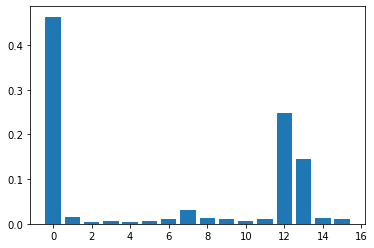

In [25]:
importance = rf.feature_importances_
print('Importance:')
for i,v in enumerate(importance):
    print('%s: %.5f' % (l[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

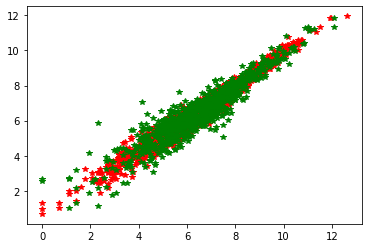

In [26]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
plt.plot(y_train, y_train_pred,'*r')
plt.plot(y_test, y_test_pred, '*g')

plt.show() 

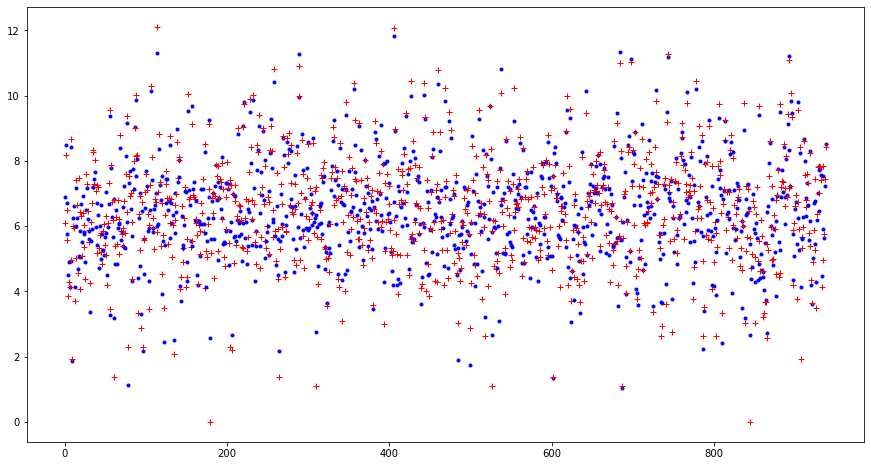

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
y_test_pred = clf.predict(x_test)
y_df = pd.DataFrame(y_test)
for i in range(len(x_test.index)):
    plt.plot(i, y_test_pred[i], '.b')
    plt.plot(i, y_df.iloc[i,0], '+r')
    
plt.show()

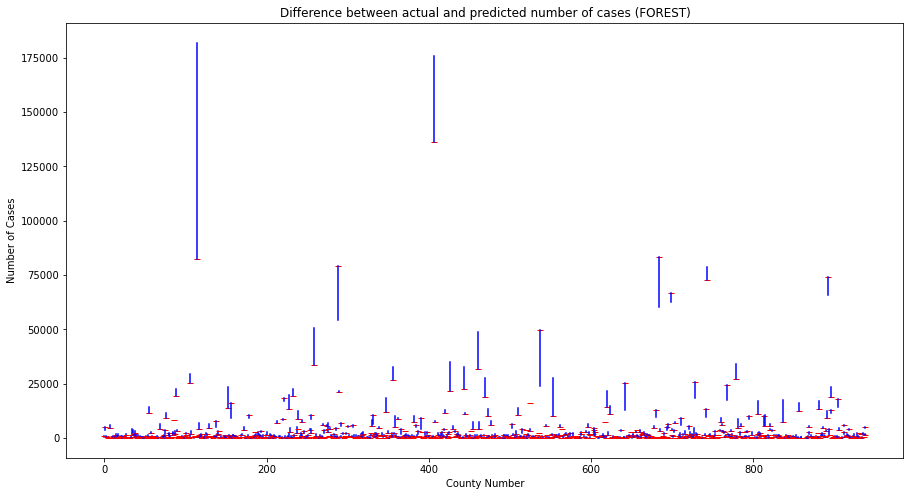

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
y_test_pred = clf.predict(x_test)
y_df = pd.DataFrame(y_test)
for i in range(len(x_test.index)):
    plt.plot(i, np.exp(y_test_pred[i]),'_r')
    plt.plot([i,i], [np.exp(y_test_pred[i]), np.exp(y_df.iloc[i,0])],'b')
plt.title("Difference between actual and predicted number of cases (FOREST)")
plt.ylabel("Number of Cases")
plt.xlabel("County Number")
plt.show()